# LoFreq variant exploration
We're also going to try the caller LoFreq, which is more specifically intended for the population genetics of haploid species.  [LoFreq](https://csb5.github.io/lofreq/) is a bit older/less recently maintained than some other tools, but is easy and fast to run. It also performs its own internal filtering, so we don't need to filter the outputs the way we do with freebayes. However, it can't be run as tumor/normal, so we will need to filter out the variatns found in the controls from those that are treatments.

In [17]:
from os import listdir
from os.path import isdir
from pysam import VariantFile
from itertools import permutations
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gzip
import seaborn as sns

## Read in data

In [4]:
rundate = '22Oct2025'
var_top_path = '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/lofreq_output/unpaired/variant_calling/lofreq/'

In [9]:
vcf_filepaths = {}
for f in listdir(var_top_path):
    if isdir(f'{var_top_path}/{f}'):
        vcf_path = f'{var_top_path}/{f}/{f}.lofreq.vcf.gz'
        vcf_filepaths[f] = vcf_path

In [11]:
def loadVCF(vcf):
    """
    Use pandas to load a vcf as a dataframe.
    """
    # Detect true header row
    try:
        with gzip.open(vcf, 'rb') as f:
            for i, l in enumerate(f.readlines()):
                if l.decode()[0] != '#':
                    header_row = i - 1 # Want the last row starting with #
                    break
    except gzip.BadGzipFile:
         with open(vcf, 'rb') as f:
            for i, l in enumerate(f.readlines()):
                if l.decode()[0] != '#':
                    header_row = i - 1 # Want the last row starting with #
                    break
                    
    # Load vcf
    df = pd.read_csv(vcf, sep='\t', header=header_row)

    return df

In [12]:
variant_dfs = {}
for name, path in vcf_filepaths.items():
    variant_dfs[name] = loadVCF(path)

A variant is uniquely defined across samples by its position; we'll remove any rows from the two treatment conditions that have the same scaffold and position number as thosei n the control.

In [13]:
for sample, df in variant_dfs.items():
    df['variant_identifier'] = list(zip(df['#CHROM'], df['POS']))

In [21]:
comparison_pairs = [p for p in permutations(variant_dfs.keys(), 2) if not '537' in p[0] and '537' in p[1]]
comparison_pairs

[('0MRep3', '537controlRep3'),
 ('0MRep3', '537controlRep2'),
 ('01MRep2', '537controlRep3'),
 ('01MRep2', '537controlRep2'),
 ('01MRep1', '537controlRep3'),
 ('01MRep1', '537controlRep2'),
 ('0MRep1', '537controlRep3'),
 ('0MRep1', '537controlRep2')]

In [22]:
filtered_treatment_samples = {}
for exp, control in comparison_pairs:
    exp_df = variant_dfs[exp]
    ctrl_df = variant_dfs[control]
    filtered_df = exp_df[~exp_df['variant_identifier'].isin(ctrl_df.variant_identifier)]
    print(f'{len(filtered_df)} of {len(exp_df)} variants ({100*(len(filtered_df)/len(exp_df)):.2f}%) are unique to sample {exp}')
    filtered_treatment_samples[f'{exp}_vs_{control}'] = filtered_df

3902 of 5720 variants (68.22%) are unique to sample 0MRep3
4011 of 5720 variants (70.12%) are unique to sample 0MRep3
3738 of 5466 variants (68.39%) are unique to sample 01MRep2
3648 of 5466 variants (66.74%) are unique to sample 01MRep2
4125 of 5970 variants (69.10%) are unique to sample 01MRep1
4233 of 5970 variants (70.90%) are unique to sample 01MRep1
3502 of 5119 variants (68.41%) are unique to sample 0MRep1
3331 of 5119 variants (65.07%) are unique to sample 0MRep1


## Examining filtered outputs
### Transition rates
Now let's plot the transition rates. We'll pair together transitions that are complements of one another, as was done in [Ossowski et al, 2014, Table 2](https://pmc.ncbi.nlm.nih.gov/articles/PMC3878865/table/T2/):
```
A:T→G:C
C:G→T:A
A:T→T:A
C:G→A:T
A:T→C:G
C:G→G:C
```

In [23]:
conversion_pairs = {
    'A:T→G:C': ['A > G', 'T > C'],
    'C:G→T:A': ['C > T', 'G > A'],
    'A:T→T:A': ['A > T', 'T > A'],
    'C:G→A:T': ['C > A', 'G > T'],
    'A:T→C:G': ['A > C', 'T > G'],
    'C:G→G:C': ['C > G', 'G > C']
}
transition_groups = {
    'A > G': 'A:T→G:C',
    'T > C': 'A:T→G:C',
    'C > T': 'C:G→T:A',
    'G > A': 'C:G→T:A',
    'A > T': 'A:T→T:A',
    'T > A': 'A:T→T:A',
    'C > A': 'C:G→A:T',
    'G > T': 'C:G→A:T',
    'A > C': 'A:T→C:G',
    'T > G': 'A:T→C:G',
    'C > G': 'C:G→G:C',
    'G > C': 'C:G→G:C'
}

In [26]:
conversions_to_plot = defaultdict(list)
for sample, df in filtered_treatment_samples.items():
    df.loc[:, 'transition'] = df['REF'] + ' > ' + df['ALT']
    df.loc[:, 'transition_group'] = [transition_groups[t] for t in df['transition']]
    trans_counts = df.groupby('transition_group').count()/len(df)
    sorted_groups = trans_counts.reindex(conversion_pairs.keys())
    for trans, rate in sorted_groups['transition'].items():
        conversions_to_plot[trans].append(rate)

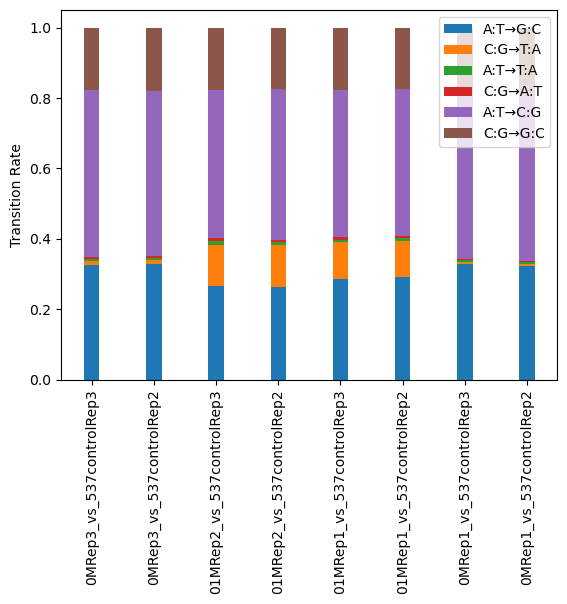

In [31]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(8)

for name, probs in conversions_to_plot.items():
    ax.bar(filtered_treatment_samples.keys(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()

What does the unfiltered data look like?

In [32]:
unfiltered_conversions_to_plot = defaultdict(list)
for sample, df in variant_dfs.items():
    df.loc[:, 'transition'] = df['REF'] + ' > ' + df['ALT']
    df.loc[:, 'transition_group'] = [transition_groups[t] for t in df['transition']]
    trans_counts = df.groupby('transition_group').count()/len(df)
    sorted_groups = trans_counts.reindex(conversion_pairs.keys())
    for trans, rate in sorted_groups['transition'].items():
        unfiltered_conversions_to_plot[trans].append(rate)

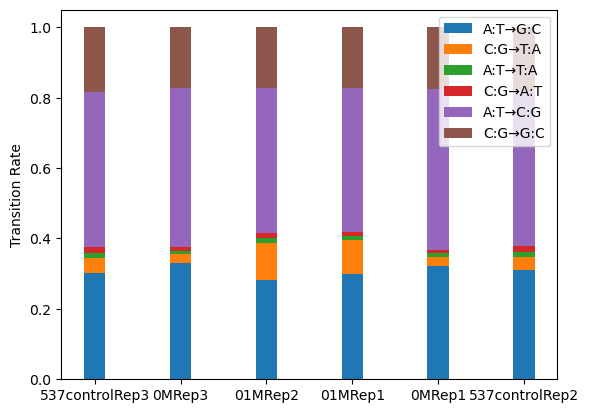

In [35]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(6)

for name, probs in unfiltered_conversions_to_plot.items():
    ax.bar(variant_dfs.keys(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='upper right')

plt.show()

### Alternate allele frequencies
What do the alternate allele frequencies look like here? Thankfully, LoFreq does this calculation for us.

In [36]:
alt_freqs = defaultdict(list)
for sample, df in filtered_treatment_samples.items():
    alts = df.INFO.str.split(';').str[1].str.split('=').str[1]
    alt_freqs[sample] = alts

In [37]:
for_violin = [(k, float(freq)) for k, v in alt_freqs.items() for freq in v]


for_violin_df = pd.DataFrame.from_records(for_violin, columns=['sample', 'alt_frequency'])
for_violin_df.head()

,sample,alt_frequency
0,0MRep3_vs_537controlRep3,0.127517
1,0MRep3_vs_537controlRep3,0.264706
2,0MRep3_vs_537controlRep3,0.168675
3,0MRep3_vs_537controlRep3,0.111111
4,0MRep3_vs_537controlRep3,0.212500


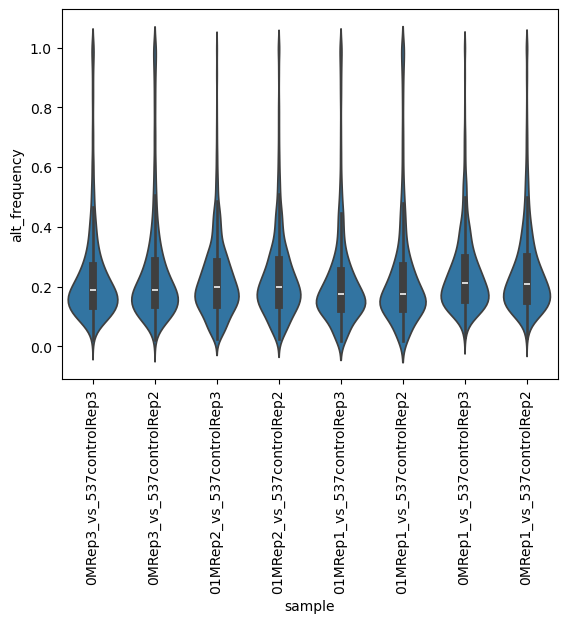

In [40]:
sns.violinplot(for_violin_df, x='sample', y='alt_frequency')
_ = plt.xticks(rotation=90)

In [42]:
for sample, alt_freq_list in alt_freqs.items():
    print(f'The maximum frequency alt in {sample} was {max(alt_freq_list)}')

The maximum frequency alt in 0MRep3_vs_537controlRep3 was 1.000000
The maximum frequency alt in 0MRep3_vs_537controlRep2 was 1.000000
The maximum frequency alt in 01MRep2_vs_537controlRep3 was 1.000000
The maximum frequency alt in 01MRep2_vs_537controlRep2 was 1.000000
The maximum frequency alt in 01MRep1_vs_537controlRep3 was 1.000000
The maximum frequency alt in 01MRep1_vs_537controlRep2 was 1.000000
The maximum frequency alt in 0MRep1_vs_537controlRep3 was 1.000000
The maximum frequency alt in 0MRep1_vs_537controlRep2 was 1.000000


In [43]:
for sample, df in filtered_treatment_samples.items():
    alts = df.INFO.str.split(';').str[1].str.split('=').str[1].astype(float)
    print(f'{len(df[alts == 1])} of {len(df)} variants has a frequency of 100%')

40 of 3902 variants has a frequency of 100%
54 of 4011 variants has a frequency of 100%
10 of 3738 variants has a frequency of 100%
26 of 3648 variants has a frequency of 100%
41 of 4125 variants has a frequency of 100%
64 of 4233 variants has a frequency of 100%
16 of 3502 variants has a frequency of 100%
26 of 3331 variants has a frequency of 100%


LoFreq reports a suspiciously large number of variants that are fixed in all populations. Combined with the fact that there is a large transition bias towards arbitrary transitions across all samples, LoFreq is not an adequate variant caller for our samples.